<a href="https://colab.research.google.com/github/chetankumar-rs/100xDevs-Cohort3-WebDev-and-Devops/blob/main/mini-project-model-trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- Standard Data Science Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import joblib  # For saving the scaler

# --- NEW: PyTorch Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# --- NEW: Scaler (CRITICAL for Neural Networks) ---
# Your original code imported but didn't use a scaler.
# For PyTorch, scaling is mandatory for good performance.
from sklearn.preprocessing import MinMaxScaler

# --- Setup for Google Colab ---
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Your Confusion Matrix Function (Copied from your notebook) ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Using device: cuda


In [3]:
# --- 1. Load Data ---
# This assumes you have uploaded your "DDos.csv" to a folder named "data" in Colab
# or you can just upload "DDos.csv" and change the path to "DDos.csv"
try:
    df = pd.read_csv("/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
    print("File loaded successfully.")
except FileNotFoundError:
    print("File 'data/DDos.csv' not found. Please upload it to your Colab environment.")
    # In a real script, you might want to stop here
    # For now, we'll let it error out if the file isn't present in the next step.

# --- 2. Clean Column Names (from your script) ---
df.columns = df.columns.str.strip()
print("Column names stripped.")

# --- 3. Handle Infinity and NaN values (from your script) ---
# Treat inf as NaN
pd.set_option('use_inf_as_na', True)
# Drop all rows with any NaN or inf values
df = df.dropna()
print(f"Data shape after dropping NaNs/Infs: {df.shape}")

# --- 4. Encode Labels (from your script) ---
df['Label'] = df['Label'].map({'BENIGN': 0, 'DDoS': 1})
print("Labels encoded.")

# --- 5. Separate Features (X) and Labels (y) ---
X = df.drop('Label', axis=1)
y = df['Label']

# Save feature names for later (good practice)
FEATURE_NAMES = X.columns.tolist()
N_FEATURES = len(FEATURE_NAMES)
print(f"Data separated: {N_FEATURES} features and 1 label.")

File loaded successfully.
Column names stripped.
Data shape after dropping NaNs/Infs: (225711, 79)
Labels encoded.
Data separated: 78 features and 1 label.


/tmp/ipython-input-3520660705.py:18: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


In [4]:
# --- 1. Split the data (same as your script) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"Train dataset size: {X_train.shape}")
print(f"Test dataset size:  {X_test.shape}")

# --- 2. Scale the Data (CRITICAL NEW STEP) ---
# Neural networks (like CNN-LSTM) require scaled features to converge properly.
# Your original code showed convergence warnings for LR and MLP because of this.
scaler = MinMaxScaler()

# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the *same* scaler
X_test_scaled = scaler.transform(X_test)

print("Data scaled using MinMaxScaler.")

# --- 3. Save the Scaler ---
# You will need this file to process data for your Student model.
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

Train dataset size: (157997, 78)
Test dataset size:  (67714, 78)
Data scaled using MinMaxScaler.
Scaler saved to scaler.pkl


In [5]:
# --- 1. Convert to PyTorch Tensors ---
# We need to use .float() for model features and .float().view(-1, 1) for labels
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print("Data converted to PyTorch Tensors.")

# --- 2. Create TensorDatasets ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# --- 3. Create DataLoaders ---
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")

Data converted to PyTorch Tensors.
DataLoaders created with batch size 64.


In [6]:
class TeacherModel(nn.Module):
    def __init__(self, n_features):
        super(TeacherModel, self).__init__()

        # --- 1D-CNN Layers ---
        # Input shape will be (batch_size, 1, n_features)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # --- LSTM Layer ---
        # The input to LSTM will have 64 features (from conv1 out_channels)
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=50,
            num_layers=1,
            batch_first=True  # This means input shape is (batch_size, seq_len, features)
        )

        # --- Fully Connected Layer ---
        self.fc = nn.Linear(50, 1) # 50 from LSTM hidden_size, 1 for binary output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x starts as (batch_size, n_features) e.g., (64, 78)

        # 1. Add a channel dimension for CNN
        # Shape becomes (batch_size, 1, n_features) e.g., (64, 1, 78)
        x = x.unsqueeze(1)

        # 2. Pass through CNN layers
        # Shape: (64, 1, 78) -> (64, 64, 78)
        x = self.conv1(x)
        x = self.relu(x)
        # Shape: (64, 64, 78) -> (64, 64, 39) (features/2 due to pooling)
        x = self.pool1(x)

        # 3. Prepare for LSTM
        # LSTM expects (batch_size, seq_len, n_features)
        # Current shape is (batch_size, n_channels, seq_len_after_pool)
        # We permute it: (64, 64, 39) -> (64, 39, 64)
        x = x.permute(0, 2, 1)

        # 4. Pass through LSTM
        # We only care about the last hidden state
        _, (hidden, _) = self.lstm(x)

        # 5. Get the last hidden state and remove the 'num_layers' dimension
        # Shape: (num_layers, batch_size, hidden_size) -> (batch_size, hidden_size)
        x = hidden.squeeze(0)

        # 6. Pass through final linear layer and sigmoid
        # Shape: (batch_size, 50) -> (batch_size, 1)
        x = self.fc(x)
        x = self.sigmoid(x)

        return x

# Instantiate the model and move it to the GPU
model = TeacherModel(n_features=N_FEATURES).to(device)
print(model)

TeacherModel(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [7]:
# --- Hyperparameters ---
LEARNING_RATE = 0.001
EPOCHS = 10  # Start with 10. You can increase this if loss is still improving.

# --- Loss and Optimizer ---
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting training...")

# --- Training Loop ---
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Forward pass
        outputs = model(inputs)

        # 2. Calculate loss
        loss = criterion(outputs, labels)

        # 3. Backward pass and optimization
        optimizer.zero_grad()  # Clear old gradients
        loss.backward()        # Calculate new gradients
        optimizer.step()       # Update model weights

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}")

print("Training finished.")

Starting training...
Epoch [1/10], Train Loss: 0.0848
Epoch [2/10], Train Loss: 0.0262
Epoch [3/10], Train Loss: 0.0248
Epoch [4/10], Train Loss: 0.0201
Epoch [5/10], Train Loss: 0.0215
Epoch [6/10], Train Loss: 0.0181
Epoch [7/10], Train Loss: 0.0172
Epoch [8/10], Train Loss: 0.0168
Epoch [9/10], Train Loss: 0.0155
Epoch [10/10], Train Loss: 0.0152
Training finished.



--- CNN-LSTM Teacher Model Evaluation Results ---
Accuracy:  0.9930
Precision: 0.9965
Recall:    0.9911
F1 Score:  0.9938


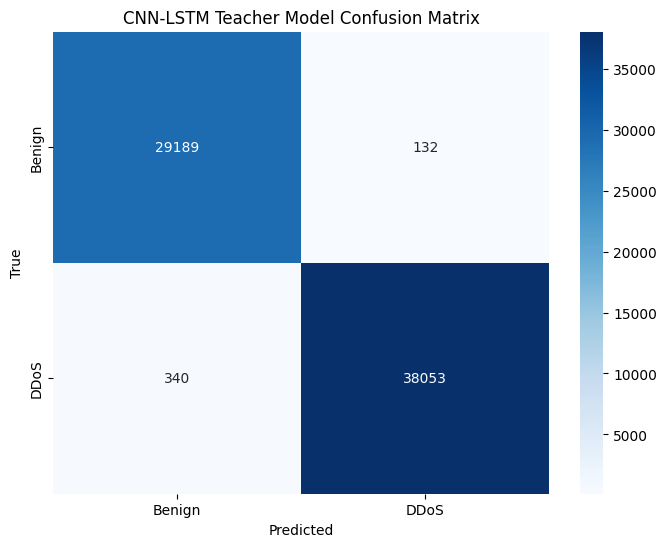

In [8]:
# --- 6. Model Evaluation ---
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

# We use torch.no_grad() to speed up computation and save memory
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)

        # Convert probabilities to binary predictions (0 or 1)
        preds = (outputs > 0.5).float()

        # Move predictions and labels back to CPU for sklearn
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics (using sklearn, just like your original code)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("\n--- CNN-LSTM Teacher Model Evaluation Results ---")
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')

# Plot the confusion matrix (using your function)
plot_confusion_matrix(all_labels, all_preds, ['Benign', 'DDoS'], 'CNN-LSTM Teacher Model Confusion Matrix')

In [9]:
# --- 7. Model "Downloading" (Saving the Model) ---

# Define a path to save the model
MODEL_PATH = "teacher_cnn_lstm.pth"

# Save the model's learned weights (its "knowledge")
torch.save(model.state_dict(), MODEL_PATH)

print(f"\n✅ Teacher model's weights saved to {MODEL_PATH}")
print("You can now see this file in the Colab file explorer on the left.")
print("\nYou now have the two files you need for the next phase:")
print(f"1. {MODEL_PATH} (The trained Teacher model)")
print(f"2. scaler.pkl (The scaler used to process the data)")


✅ Teacher model's weights saved to teacher_cnn_lstm.pth
You can now see this file in the Colab file explorer on the left.

You now have the two files you need for the next phase:
1. teacher_cnn_lstm.pth (The trained Teacher model)
2. scaler.pkl (The scaler used to process the data)


In [10]:
# --- 8. Define the Lightweight Student Model (MLP) ---

class StudentModel(nn.Module):
    def __init__(self, n_features):
        super(StudentModel, self).__init__()

        # A simple 3-layer network
        self.fc1 = nn.Linear(n_features, 40) # 78 -> 40
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(40, 20)         # 40 -> 20
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(20, 1)          # 20 -> 1 (output)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # No reshaping needed for a simple MLP
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

print("StudentModel class defined.")

StudentModel class defined.


In [11]:
# --- 9. Define the Knowledge Distillation Loss Function ---

class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, T, alpha):
        super(KnowledgeDistillationLoss, self).__init__()
        self.T = T
        self.alpha = alpha
        self.KLD_loss = nn.KLDivLoss(reduction='batchmean')
        self.BCE_loss = nn.BCELoss()

    def forward(self, student_outputs, teacher_outputs, labels):
        # 1. Hard Loss (standard loss)
        # Compare student's normal output to the true labels
        loss_hard = self.BCE_loss(student_outputs, labels)

        # 2. Soft Loss (distillation loss)
        # Soften the outputs from both models using the Temperature
        student_soft = F.log_softmax(student_outputs / self.T, dim=1)
        teacher_soft = F.softmax(teacher_outputs / self.T, dim=1)

        # Compare the softened outputs
        # We multiply by T*T as per the original distillation paper
        loss_soft = self.KLD_loss(student_soft, teacher_soft) * (self.T * self.T)

        # 3. Combine the losses
        # L_KD = (alpha * Hard_Loss) + ((1 - alpha) * Soft_Loss)
        total_loss = (self.alpha * loss_hard) + ((1.0 - self.alpha) * loss_soft)

        return total_loss

print("KnowledgeDistillationLoss class defined.")

KnowledgeDistillationLoss class defined.


In [12]:
# --- 10. Load Teacher and Create Student ---

# 1. Instantiate the Teacher model
# (We need the class definition from before)
teacher_model = TeacherModel(n_features=N_FEATURES).to(device)

# 2. Load the saved weights
teacher_model.load_state_dict(torch.load("teacher_cnn_lstm.pth"))

# 3. Set Teacher to "evaluation mode"
# This is CRITICAL. It freezes the weights so it doesn't train.
teacher_model.eval()

# 4. Instantiate the Student model
student_model = StudentModel(n_features=N_FEATURES).to(device)

print("Teacher model loaded and frozen.")
print("Student model created.")

# --- Hyperparameters for Distillation ---
# From your project plan
T = 4.0      # Temperature
alpha = 0.7  # Weight for hard loss

# --- Loss and Optimizer for STUDENT ---
criterion_kd = KnowledgeDistillationLoss(T=T, alpha=alpha)

# CRITICAL: We only create an optimizer for the STUDENT's parameters.
# The teacher's weights will not be changed.
LEARNING_RATE_STUDENT = 0.001
optimizer_student = optim.Adam(student_model.parameters(), lr=LEARNING_RATE_STUDENT)

print("Distillation loss and student optimizer are ready.")

Teacher model loaded and frozen.
Student model created.
Distillation loss and student optimizer are ready.


In [13]:
# --- 11. Distillation Training Loop ---
EPOCHS_STUDENT = 10 # Train for the same number of epochs

print("Starting Knowledge Distillation training...")

for epoch in range(EPOCHS_STUDENT):
    student_model.train()  # Put student in train mode
    total_student_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Get Teacher's "soft" predictions
        # We use torch.no_grad() because we don't need to
        # calculate gradients for the teacher.
        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)

        # 2. Get Student's predictions
        student_outputs = student_model(inputs)

        # 3. Calculate the special distillation loss
        loss = criterion_kd(student_outputs, teacher_outputs, labels)

        # 4. Backward pass and optimization (for STUDENT only)
        optimizer_student.zero_grad()
        loss.backward()
        optimizer_student.step()

        total_student_loss += loss.item()

    avg_student_loss = total_student_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS_STUDENT}], Student Loss: {avg_student_loss:.4f}")

print("Student training finished.")

Starting Knowledge Distillation training...
Epoch [1/10], Student Loss: 0.0376
Epoch [2/10], Student Loss: 0.0113
Epoch [3/10], Student Loss: 0.0083
Epoch [4/10], Student Loss: 0.0062
Epoch [5/10], Student Loss: 0.0047
Epoch [6/10], Student Loss: 0.0037
Epoch [7/10], Student Loss: 0.0031
Epoch [8/10], Student Loss: 0.0028
Epoch [9/10], Student Loss: 0.0024
Epoch [10/10], Student Loss: 0.0023
Student training finished.



--- Lightweight MLP Student Model Evaluation Results ---
Accuracy:  0.9994
Precision: 0.9999
Recall:    0.9991
F1 Score:  0.9995


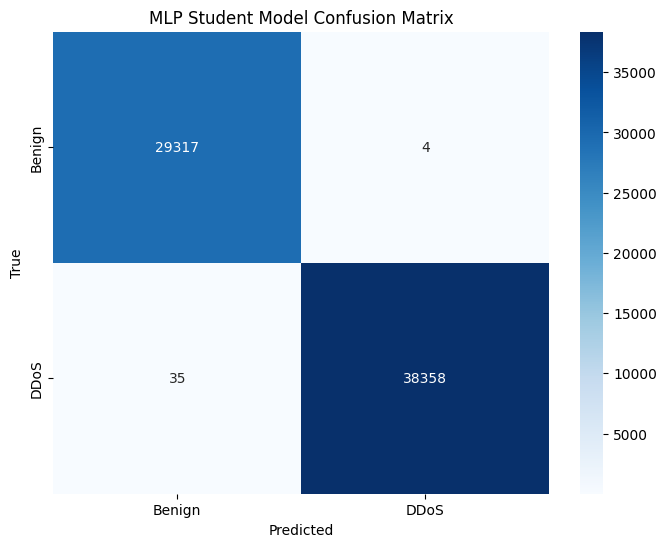

In [14]:
# --- 12. Evaluate the Lightweight Student Model ---

student_model.eval()  # Set student to evaluation mode
all_preds_student = []
all_labels_student = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get STUDENT'S predictions
        outputs = student_model(inputs)

        preds = (outputs > 0.5).float()

        all_preds_student.extend(preds.cpu().numpy())
        all_labels_student.extend(labels.cpu().numpy())

# Calculate metrics
accuracy_s = accuracy_score(all_labels_student, all_preds_student)
precision_s = precision_score(all_labels_student, all_preds_student)
recall_s = recall_score(all_labels_student, all_preds_student)
f1_s = f1_score(all_labels_student, all_preds_student)

print("\n--- Lightweight MLP Student Model Evaluation Results ---")
print(f'Accuracy:  {accuracy_s:.4f}')
print(f'Precision: {precision_s:.4f}')
print(f'Recall:    {recall_s:.4f}')
print(f'F1 Score:  {f1_s:.4f}')

# Plot the confusion matrix
plot_confusion_matrix(all_labels_student, all_preds_student, ['Benign', 'DDoS'], 'MLP Student Model Confusion Matrix')

In [16]:
# --- 13. Save the Final Lightweight Student Model ---

STUDENT_MODEL_PATH = "student_mlp_model.pth"
torch.save(student_model.state_dict(), STUDENT_MODEL_PATH)

print(f"\n✅ Lightweight Student model saved to {STUDENT_MODEL_PATH}")


✅ Lightweight Student model saved to student_mlp_model.pth
